<a href="https://colab.research.google.com/github/gchiuffa/learning/blob/master/newyorktaxi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading

Downloading dataset TAXI FARE NEW YORK CITY PREDICTION- Runtime set to GPU 

In [38]:
!pip install kaggle 


In [50]:
!mkdir .kaggle #create a diretory

mkdir: cannot create directory ‘.kaggle’: File exists


In [0]:
#my login
import json
token = {"username":"gchiuffa","key":"43f8ce985240d97c07421e4b5cd940f0"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file) 

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [60]:
#download dataset
!kaggle competitions download -c new-york-city-taxi-fare-prediction

  0% 0.00/335k [00:00<?, ?B/s]
100% 335k/335k [00:00<00:00, 54.2MB/s]
  0% 0.00/960k [00:00<?, ?B/s]
100% 960k/960k [00:00<00:00, 63.4MB/s]
 99% 1.55G/1.56G [00:33<00:00, 52.1MB/s]
100% 1.56G/1.56G [00:33<00:00, 50.5MB/s]
  0% 0.00/486 [00:00<?, ?B/s]
100% 486/486 [00:00<00:00, 428kB/s]


Unzip trian set 


In [0]:
!unzip \*.zip

Archive:  train.csv.zip
  inflating: train.csv               


# Import libs that will be used

In [0]:
import numpy as np # linear algebra
import pandas as pd 
import os # reading the input files we have access to
import matplotlib.pyplot as plt #plot
import seaborn as sns #plot
import sklearn  #machine learning models
% matplotlib inline
plt.style.use('seaborn-whitegrid')

from datetime import datetime #datetime manipulation 


# Problem Definition

**The aim of these task is to predict the new york taxi fare given six variables (pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count)**

I believe that other variables are related to the amount of fare.




*   **Total distance** - I can get data by transforming the longitude e latitude variables 
*   **Weather** - because it changes the traffic intensity and demand. (I can use the forecast of the variable pickup_datetime - or separate the data by year stations)
*   **Time along the day** - it changes the trafic intensity, also the rule of fares normally changes 

#Exploring Variable 

Let start checking and understanding the distribution of target and given variables. And excluding possible noise, outliers, and missing values 

- noise - amount fare negative or equal to zero 
- outliers 
- missing values - drop any row with missing values 

In [0]:
train_df =  pd.read_csv('train.csv', nrows = 10_000_000) #read the csv file (10000000 rows)
#train_df.dtypes

In [0]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.000000e+07,1.000000e+07,1.000000e+07,9.999931e+06,9.999931e+06,1.000000e+07
mean,1.133854e+01,-7.250775e+01,3.991934e+01,-7.250897e+01,3.991913e+01,1.684793e+00
std,9.799930e+00,1.299421e+01,9.322539e+00,1.287532e+01,9.237280e+00,1.323423e+00
min,-1.077500e+02,-3.439245e+03,-3.492264e+03,-3.426601e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073491e+01,-7.399139e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396710e+01,4.076712e+01,-7.396367e+01,4.076810e+01,2.000000e+00
max,1.273310e+03,3.457626e+03,3.344459e+03,3.457622e+03,3.351403e+03,2.080000e+02


Checking missing values 

In [0]:
print(train_df.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [0]:
train_df = train_df.dropna()

There are some negative fare_amount what is not realistic, to correct, these data can be excluded. Or we can assume a abs value of fare_amount






As the data sample are not significativaly reduced by taking the negative values out, I ll use these aproach insted to take the abs. 






In [0]:
atributes = ['fare_amount','passenger_count', 
        'pickup_longitude', 'dropoff_longitude',
        'pickup_latitude', 'dropoff_latitude']

def bplot(df,atributes):
  length = len(atributes)


  plt.figure(figsize = (13,15))
  for j in (range(length)):
      plt.subplot(length/2,length/3,j+1)
      sns.boxplot(atributes[j], data=df)
      plt.title(atributes[j],color = "b")
      plt.xlabel("")
      
 

The boxplot gives us a good vizualization of the distribution of data and possible outliers

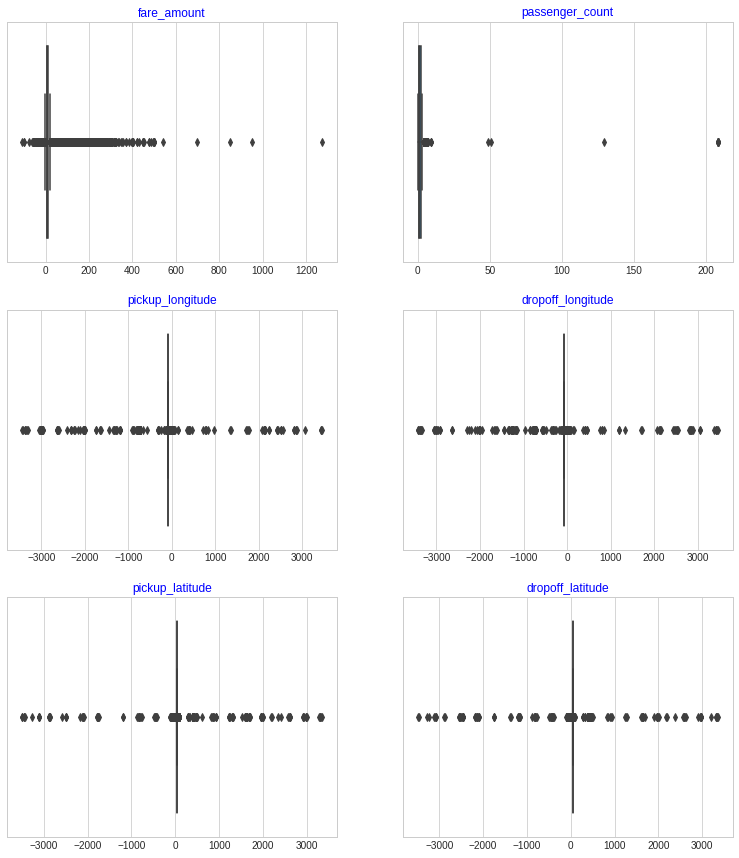

In [0]:
bplot(train_df,atributes)

There are some  outliers, to correct that I removed these data points

In [0]:
train_df2=train_df.copy()
#drop observations with passengers greater than 6 and equals 0
train_df2 = train_df2[(train_df2["passenger_count"] > 0) &
                    (train_df2["passenger_count"] < 7) ]

#drop observations with fareamount  less than 0 and  greater than 99.99% percentile value.
train_df2 = train_df2[ (train_df2["fare_amount"] > 0 ) &
                     (train_df2["fare_amount"]  <  
                      train_df2["fare_amount"].quantile(.9999))]

#drop outlier observations in data by less than 10% or more than 90% percentile value
coords = ['pickup_longitude','pickup_latitude', 
          'dropoff_longitude', 'dropoff_latitude']
for i in coords: 
    train_df2 = train_df2[(train_df2[i]   > train_df2[i].quantile(.1)) & 
                        (train_df2[i] < train_df2[i].quantile(.9))]

train_df2.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,4.080618e+06,4.080618e+06,4.080618e+06,4.080618e+06,4.080618e+06,4.080618e+06
mean,7.682031e+00,-7.398022e+01,4.075484e+01,-7.398006e+01,4.075505e+01,1.675802e+00
std,3.742681e+00,1.221998e-02,1.288334e-02,1.162179e-02,1.193018e-02,1.302339e+00
min,1.000000e-02,-7.400279e+01,4.072681e+01,-7.400202e+01,4.072892e+01,1.000000e+00
25%,5.300000e+00,-7.398965e+01,4.074548e+01,-7.398910e+01,4.074669e+01,1.000000e+00
50%,6.900000e+00,-7.398187e+01,4.075592e+01,-7.398132e+01,4.075600e+01,1.000000e+00
75%,9.000000e+00,-7.397230e+01,4.076414e+01,-7.397269e+01,4.076374e+01,2.000000e+00
max,1.480000e+02,-7.395073e+01,4.078012e+01,-7.395272e+01,4.077866e+01,6.000000e+00


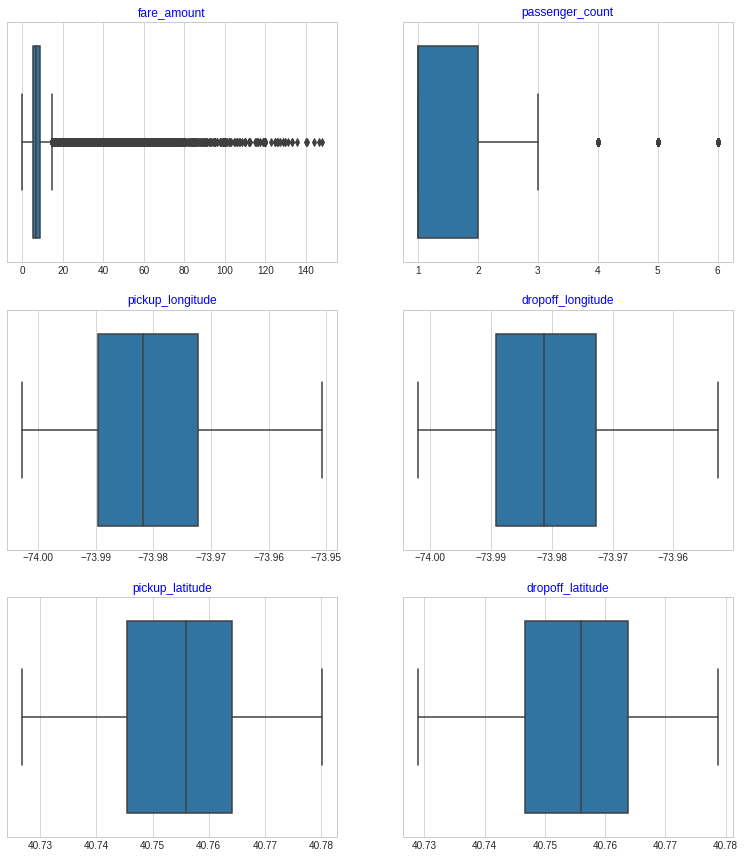

In [0]:
bplot(train_df2,atributes)

In [0]:
len(train_df2)/len(train_df)

## **Variables** **Histograms**

In [0]:
#function to plot the histrogram os the variables, as the boxplot it is a good vizualization of the data distribution.
#There are a adicional information on the histogram plot, i can see the kind of distrbution of data 
#The box plot shows the means and quartiles, which give us a idea of how the data is spreaded around the mean.
import itertools
atributes = ['fare_amount','passenger_count', 
        'pickup_longitude', 'dropoff_longitude',
        'pickup_latitude', 'dropoff_latitude']

length = len(atributes)

def dplot(df,atributes,length):
  sns.set_style("darkgrid")
  plt.figure(figsize = (13,15))
  for i,j in itertools.zip_longest(atributes,range(length)) : #
      plt.subplot(length/2,length/3,j+1)
      sns.distplot(train_df2[i])
      plt.title(i,color = "k")
      plt.xlabel("")

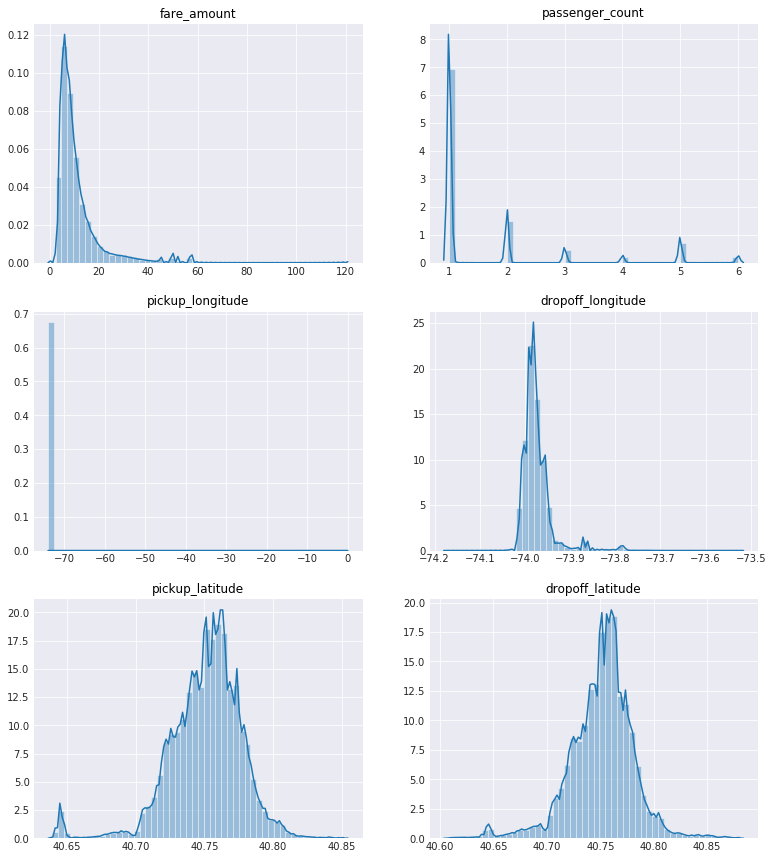

In [0]:
dplot(train_df2,atributes,length)

##Explore scatter of location distribution pick up and dropoff

Based on https://www.kaggle.com/drgilermo/dynamics-of-new-york-city-animation

These plot is good to explore the density and distrbution of position variables considering the nyc structure. I can have a idea where the pickup or dropoff are more frequent considering the points density. It can be used to engineering variables of importante points of city, as airports, turistics points. Also can be used to visualize and estimate the trafic density of some areas of city. 

In [0]:
def plot_hires1(df, figsize=(12, 12), ax=None, c=('r', 'b')):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

 #   idx = select_within_boundingbox(df, BB)
    ax.scatter(df.pickup_longitude, df.pickup_latitude, c=c[0], s=0.01, alpha=0.5)
    ax.scatter(df.dropoff_longitude, df.dropoff_latitude, c=c[1], s=0.01, alpha=0.5)

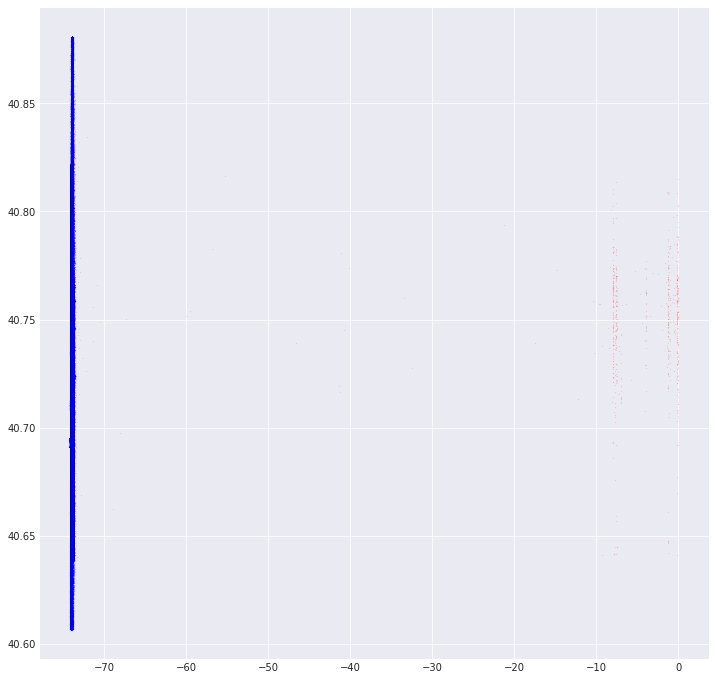

In [0]:
plot_hires1(train_df2)

the graph is too spread and it is hard to see something, so it is necessary to select a range o latitude and longitude, a good aproach to do that is search nyc bounduaries on google 

new version of function to plot using bounduaries

In [0]:
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])

In [0]:
def plot_hires(df, B, flag, figsize=(12, 12), ax=None, c=('r', 'b')):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        plt.xlabel('Longitude')
        
    idx = select_within_boundingbox(df, B)
    if flag=='pickup':
        ax.scatter(df[idx].pickup_longitude, df[idx].pickup_latitude, c=c[0], s=0.01, alpha=0.5)
    elif flag == 'dropoff':
         ax.scatter(df[idx].dropoff_longitude, df[idx].dropoff_latitude, c=c[1], s=0.01, alpha=0.5)
    else:
         ax.scatter(df[idx].pickup_longitude, df[idx].pickup_latitude, c=c[0], s=0.01, alpha=0.5)
         ax.scatter(df[idx].dropoff_longitude, df[idx].dropoff_latitude, c=c[1], s=0.01, alpha=0.5)



      

The scatter give us a idea of density of points on dropoff and pickup 

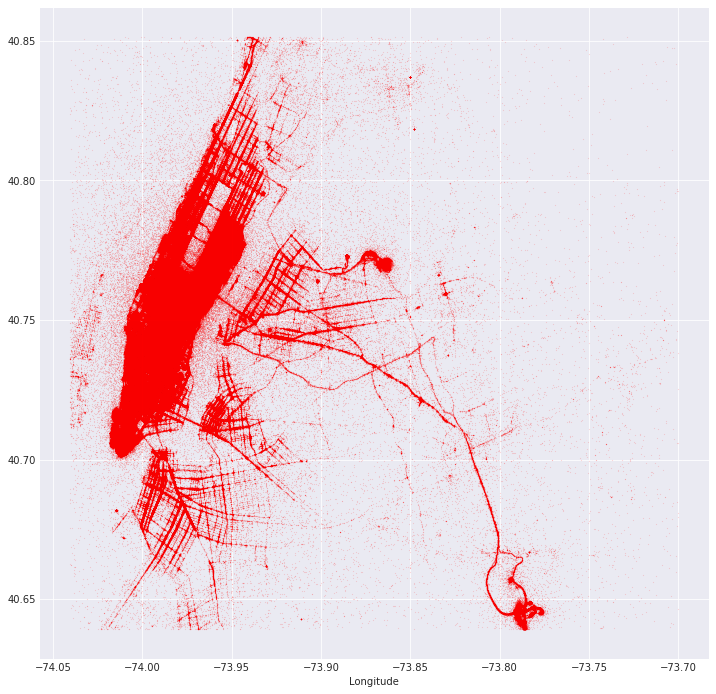

In [0]:
plot_hires(train_df2, (-74.1, -73.7, 40.6, 40.9),'pickup')



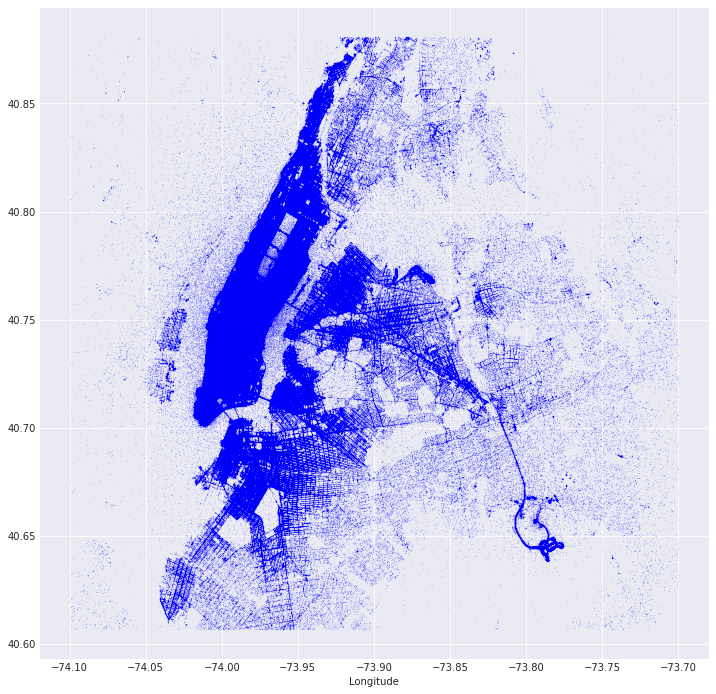

In [0]:
plot_hires(train_df2, (-74.1, -73.7, 40.6, 40.9),'dropoff')


#Feature Engineering

1.   Distance
2.   Date

###1.Distance

The distance is likely related to the fare amout. I can get these by using the longitude and latitude variables:

The haversine distance is a method to calculate the distance between two points in the earth

https://www.geeksforgeeks.org/program-distance-two-points-earth/

In [0]:
from math import radians, cos, sin, asin, sqrt 
def distance_haversine(df): 
   
    # The math module contains a function named 
    # radians which converts from degrees to radians.
    lon1 = np.radians(df.pickup_longitude)
    lon2 = np.radians(df.dropoff_longitude)
    
    lat1 = np.radians(df.pickup_latitude)
    lat2 = np.radians(df.dropoff_latitude)
       
    # Haversine formula  
    dlon = lon2 - lon1  
    dlat = lat2 - lat1 
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
  
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))  
    
    R = 6371
    
    d=R*c
    # Radius of earth in kilometers. Use 3956 for miles 
    df['distance_haversine'] = d
       
    # calculate the result 
    return(d) 

There is another way to calculate distance. It uses the distance in km and trigonometry

https://www.kaggle.com/ojones3/feature-engineering-corrected-manhattan-distance

Considering, 1 degree of Latitude is equal to 110.567 km. And at 40 degrees north or south (NYC), the distance between a degree of longitude is 53 miles (85 kilometers)



In [0]:
def distance_manhattan(df):
    a =pd.DataFrame()
    #calc abs distance
    a['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    a['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()
    #convert distance to mile 
    a['abs_diff_longitude'] = a.abs_diff_longitude*85
    a['abs_diff_latitude'] = a.abs_diff_latitude*110
    #adjust by using trigonometri
    meas_ang = 0.506
    a['Euclidean'] = np.sqrt(a.abs_diff_latitude**2 + a.abs_diff_longitude**2) 
    a['delta_manh_long'] = (a.Euclidean*np.sin(np.arctan(a.abs_diff_longitude / a.abs_diff_latitude)-meas_ang)).abs()
    a['delta_manh_lat'] = (a.Euclidean*np.cos(np.arctan(a.abs_diff_longitude / a.abs_diff_latitude)-meas_ang)).abs()
    df['manh_length'] = a.delta_manh_long + a.delta_manh_lat
    #a['Euc_error'] = (df['manh_length'] - df['Euclidean'])*100 /  df['Euclidean']
    
    

In [0]:
distance_haversine(train_df2)
distance_manhattan(train_df2)

##2.Date

The trafic density normally changes acording to the hour of day, and days of week, which changes the trip duration, and consequently the fare amount 
Moreover, the weather is differente acording to the month, I believe that winter months increase the demand of taxi, and also are related to trafic density. 


In [0]:
train_df2["pickup_datetime"] =train_df2["pickup_datetime"].str.replace(" UTC","")
train_df2["pickup_datetime"] = pd.to_datetime(train_df2["pickup_datetime"],
                                             format="%Y-%m-%d %H:%M:%S")

In [0]:
def date_transform(df):
  df["pickup_datetime"] =df["pickup_datetime"].str.replace(" UTC","")
  df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"],
                                             format="%Y-%m-%d %H:%M:%S")
  df['hour'] = df.pickup_datetime.apply(lambda t: pd.to_datetime(t).hour)
  df['year'] = df.pickup_datetime.apply(lambda t: pd.to_datetime(t).year)
  df['weekday'] = df.pickup_datetime.apply(lambda t: pd.to_datetime(t).weekday())
  df['month'] = df.pickup_datetime.apply(lambda t: pd.to_datetime(t).month)


In [0]:
train_df2=train_df2.dropna() #if i have time correct that to a imputer of median


Distribution of new variables 

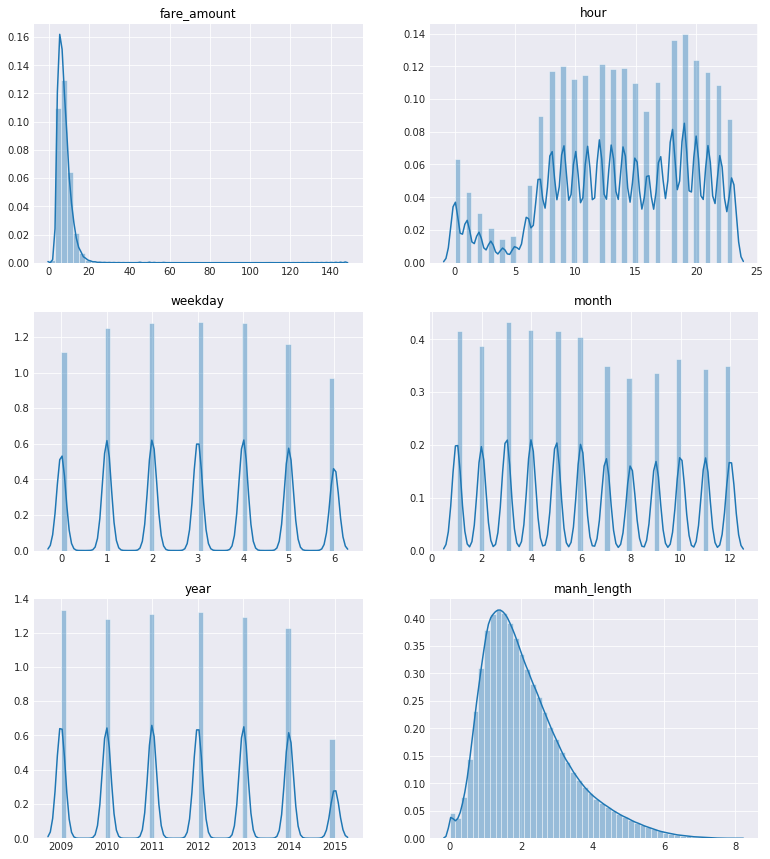

In [0]:
import itertools
atributes2= ['fare_amount','hour', 
        'weekday', 'month',
        'year', 'manh_length']

length = len(atributes2)

dplot(train_df2, atributes2, length)

save the file with these transformations so I dont have to load again 

In [0]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at drive


In [0]:
train_df2.to_csv('train_df2.csv')
!cp train_df2.csv drive/My\ Drive/

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Exploring correlations

In [0]:
atributes2= ['hour', 
        'weekday', 'month',
        'year', 'manh_length']
cols = atributes + atributes2
sns.pairplot(train_df2[cols])


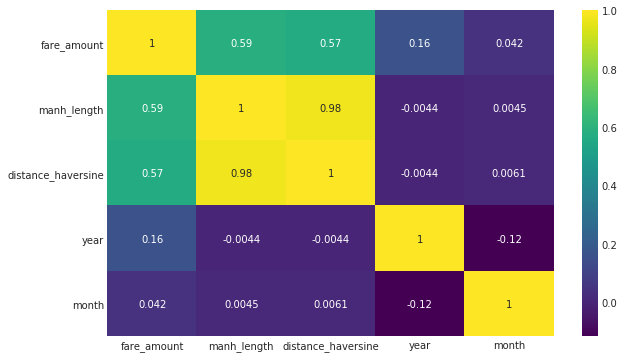

In [0]:
k = 5 #number of variables for heatmap
cols = train_df2.corr().nlargest(k, 'fare_amount')['fare_amount'].index
cm = train_df2[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')

In [0]:
a = ["trip_distance_km"]
b = ["manh_length"]
def scatterplot(df,a):
  plt.scatter(df[a], df.fare_amount, c='b', s=0.01, alpha=0.5)
  plt.xlabel(a)
  plt.ylabel('fare_amout')

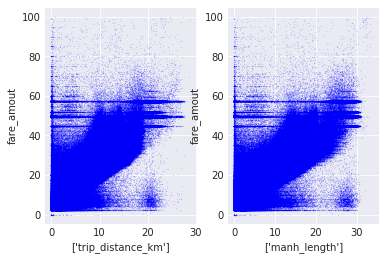

In [0]:
plt.subplot(1,2,1)
scatterplot(train_df3,a)
plt.subplot(1,2,2)
scatterplot(train_df3,b)

In [0]:
train_df3.drop(['trip_distance_km', 'log_trip_ditance'], axis=1)
corr_matrix=train_df3.corr()
corr_matrix["fare_amount"].sort_values(ascending=False)

#Organizing DATA

In [0]:
#drop missing data nan
train_df = train_df.dropna()
print(len(train_df))

train_df2 = train_df.copy()

#drop observations with passengers greater than 6 and equals 0
train_df2 = train_df2[(train_df2["passenger_count"] > 0) &
                    (train_df2["passenger_count"] < 7) ]

#drop observations with fareamount  less than 0 and  greater than 99.99% percentile value.
train_df2 = train_df2[ (train_df2["fare_amount"] > 0 ) &
                     (train_df2["fare_amount"]  <  
                      train_df2["fare_amount"].quantile(.9))]

#drop outlier observations in data
coords = ['pickup_longitude','pickup_latitude', 
          'dropoff_longitude', 'dropoff_latitude']
for i in coords: 
    train_df2 = train_df2[(train_df2[i]   > train_df2[i].quantile(.1)) & 
                        (train_df2[i] < train_df2[i].quantile(.9))]

train_df2.describe()

    
distance_manhattan(train_df2)

date_transform(train_df2)

train_df2 = train_df2.dropna()



Before run the model it is a good pratice scale the numeric data. However, when I scaled the variables the predictors decreases it performance, maybe the original structure of information is important. 


In [0]:
from sklearn import preprocessing
train_df2_num=train_df2.drop(['fare_amount','hour', 
        'weekday', 'month',
        'year', 'pickup_datetime', 'key','distance_haversine'], axis=1)
scaler = preprocessing.Normalizer()
scaled_df = scaler.fit_transform(train_df2_num)
scaled_df = pd.DataFrame(scaled_df)
scaled_df.head()
atributes=[ 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'manh_length']
train_df3=train_df2.copy

for i in range(6):
  a=atributes[i]
  train_df3[a]=scaled_df.iloc[:,i]



In [0]:
train_df2 =  pd.read_csv('/content/drive/My Drive/train_df2.csv') #dataset saved

In [0]:
train_df2=train_df2.drop('Unnamed: 0', axis=1)


In [6]:
train_df2.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_haversine,manh_length,hour,year,weekday,month
count,4.034383e+06,4.034383e+06,4.034383e+06,4.034383e+06,4.034383e+06,4.034383e+06,4.034383e+06,4.034383e+06,4.034383e+06,4.034383e+06,4.034383e+06,4.034383e+06
mean,7.668421e+00,-7.398021e+01,4.075485e+01,-7.398005e+01,4.075506e+01,1.675053e+00,1.751479e+00,2.130509e+00,1.367438e+01,2.011713e+03,2.925918e+00,6.242873e+00
std,3.631877e+00,1.222329e-02,1.289048e-02,1.161813e-02,1.192637e-02,1.301428e+00,1.000541e+00,1.189806e+00,6.012941e+00,1.869237e+00,1.926008e+00,3.446937e+00
min,1.000000e-02,-7.400279e+01,4.072681e+01,-7.400202e+01,4.072892e+01,1.000000e+00,8.420908e-05,1.155467e-04,0.000000e+00,2.009000e+03,0.000000e+00,1.000000e+00
25%,5.300000e+00,-7.398965e+01,4.074549e+01,-7.398909e+01,4.074672e+01,1.000000e+00,1.025773e+00,1.257132e+00,9.000000e+00,2.010000e+03,1.000000e+00,3.000000e+00
50%,6.900000e+00,-7.398187e+01,4.075592e+01,-7.398131e+01,4.075600e+01,1.000000e+00,1.535447e+00,1.882583e+00,1.400000e+01,2.012000e+03,3.000000e+00,6.000000e+00
75%,9.000000e+00,-7.397229e+01,4.076415e+01,-7.397269e+01,4.076375e+01,2.000000e+00,2.257238e+00,2.761609e+00,1.900000e+01,2.013000e+03,5.000000e+00,9.000000e+00
max,1.480000e+02,-7.395073e+01,4.078012e+01,-7.395272e+01,4.077866e+01,6.000000e+00,7.052535e+00,8.051025e+00,2.300000e+01,2.015000e+03,6.000000e+00,1.200000e+01


# Testing some models 

##split data

In [0]:
features=['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'manh_length', 'year', 'hour', 'weekday','month']
X = train_df2[features].values
y = train_df2['fare_amount'].values

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Simple and fast method to have a idea of performance using these features

##Linear Regression


In [0]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

In [41]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

scores = cross_validate(lin_reg, X_train, y_train, cv=30,scoring=('r2', 'neg_mean_squared_error'),
                        return_train_score=True)

print(scores['test_neg_mean_squared_error']) 
print(scores['train_r2']) 

[-8.27804052 -8.11566396 -8.69750937 -8.61914179 -8.01702919 -8.61113289
 -7.56416683 -8.18752639 -8.2161236  -7.96967409 -8.01059544 -8.00165013
 -7.44695351 -8.0397943  -8.41043648 -7.97720901 -7.72078513 -8.18820895
 -8.54547406 -7.99948256 -8.13946291 -8.28714194 -7.92194492 -8.74682126
 -8.55792169 -8.19118577 -8.43177522 -8.43225051 -8.09713821 -8.37829499]
[0.37963947 0.37942806 0.38009497 0.38000607 0.3792772  0.38004281
 0.37875063 0.37945527 0.37934264 0.37914791 0.37928565 0.37917736
 0.37870508 0.37943887 0.37977282 0.37937381 0.37894724 0.37950318
 0.38002401 0.37929746 0.3795588  0.37961308 0.37938567 0.38012394
 0.37996317 0.37937003 0.37982088 0.37976029 0.37937635 0.37963808]


In [42]:
lin_reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
prediction1=lin_reg.predict(X_test)

In [44]:
lin_mse = mean_squared_error(y_test, prediction1)
lin_mse

8.152704773288905

Text(0.5, 0, '')

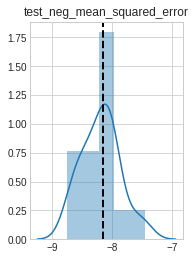

In [46]:
plt.subplot(121)
sns.distplot(scores['test_neg_mean_squared_error'])
plt.axvline((-lin_mse),linewidth  = 2 ,
                linestyle = "dashed",color = "k",
                label = "lin_mse")
plt.title('test_neg_mean_squared_error')
plt.xlabel("")

Acording to the plot the test score is at the center of the validation scores distribution. Therefore, probably it is not overfiting.

##Decision Tree Regressor

In [47]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()


scores_tree = cross_validate(tree_reg, X_train, y_train, cv=10,scoring=('r2', 'neg_mean_squared_error'),
                        return_train_score=True)
print(scores_tree['test_neg_mean_squared_error']) 
print(scores_tree['train_r2'])

[-14.49213889 -14.34064234 -13.88159896 -13.72599248 -13.80011199
 -13.94240329 -14.33600914 -14.34311137 -14.19900206 -14.18447035]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [49]:
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [0]:
prediction2=tree_reg.predict(X_test)

In [52]:
lin_mse = mean_squared_error(y_test, prediction2)
lin_mse

13.972759550503872

Text(0.5, 0, '')

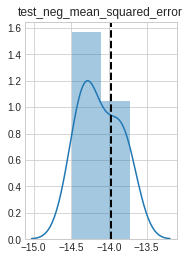

In [54]:
plt.subplot(121)
sns.distplot(scores_tree['test_neg_mean_squared_error'])
plt.axvline((-lin_mse),linewidth  = 2 ,
                linestyle = "dashed",color = "k",
                label = "lin_mse")
plt.title('test_neg_mean_squared_error')
plt.xlabel("")

It is worse than the linear regression model, and the test score is at the right of the peak of cross validation scores distribution. 

##Random Forest 

Random Forest is a ensemble method that combine n decisions trees. I expect it will present a better performance. 

In [11]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()

forest_reg.fit(X_train,y_train)

scores_forest = cross_validate(forest_reg, X_train, y_train, cv=10, scoring=('r2', 'neg_mean_squared_error'),
                        return_train_score=True)

print(scores_forest['test_neg_mean_squared_error']) 
print(scores_forest['train_r2'])

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[-7.41572909 -7.25195626 -7.14785562 -7.62696616 -7.34572868 -7.33097657
 -7.36845804 -7.31698928 -7.24534657 -7.18836117]
[0.89916467 0.90015734 0.89944929 0.90014076 0.89925203 0.89891172
 0.90043589 0.89982601 0.90053392 0.89918148]


Lets check feature importance. 

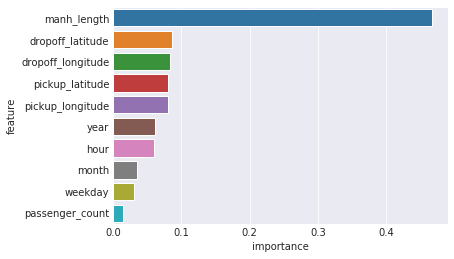

In [0]:
feature_importance = forest_reg.feature_importances_
a=pd.DataFrame(sorted(zip(feature_importance, features), reverse=True)) #combine features importances with features label
a.head()
a['importance']=a.iloc[:,0]
a['feature']=a.iloc[:,1]
sns.barplot(x="importance", y="feature", data=a)

The distribution off scores can give us a idea about the overfiting of data.

In [0]:
prediction = forest_reg.predict(X_test)

In [15]:
lin_mse = mean_squared_error(y_test, prediction)
lin_mse

7.46653274395794

Text(0.5, 0, '')

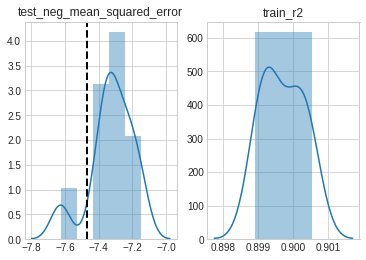

In [16]:
plt.subplot(121)
sns.distplot(scores_forest['test_neg_mean_squared_error'])
plt.title('test_neg_mean_squared_error')
plt.xlabel("")
plt.axvline((-lin_mse),linewidth  = 2 ,
                linestyle = "dashed",color = "k",
                label = "lin_mse")

plt.subplot(122)
sns.distplot(scores_forest['train_r2'])
plt.title('train_r2')
plt.xlabel("")


In [0]:
result=pd.DataFrame()
result['prediction']=prediction
result['real']=y_test

In [0]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(y_test, prediction)
lin_mse

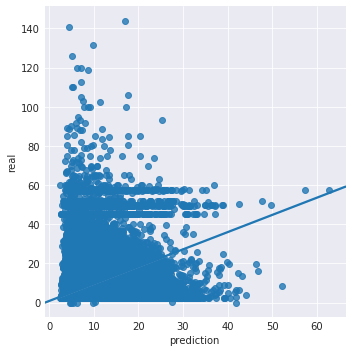

In [0]:
sns.lmplot('prediction','real',data=result, fit_reg=True)

The model is overfiting, it can be regularized by controlling the tree depth. The tuning will help improve that.

Also, the model is making more mistakes for high fare trips, maybe it is necessary to look for the data again to get more insights about these trips and create new features. 

#Tuning model Random Forest

We can try improve the performance of the Random Forest model by selecting its hyperparameters. In order to do that we use a method that combine of parameters (gridsearch) to optimize the performance of the model. 

The hyperparametes for Random Forest are:

1.  n_estimators = number of trees in the forest
2.  max_features = max number of features considered for splitting a node
3.  max_depth = max number of levels in each decision tree
4.  min_samples_split = min number of data points placed in a node before the node is split
5.  min_samples_leaf = min number of data points allowed in a leaf node
6.  bootstrap = method for sampling data points (with or without replacement)





In [0]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
forest_reg = RandomForestRegressor()

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 100)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(1, 45, num = 3)]
min_samples_split = [5, 10]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

rf_random = RandomizedSearchCV(estimator = forest_reg, param_distributions = random_grid,
                               n_iter = 10, cv = 10, verbose=2, random_state=42, scoring='neg_mean_squared_error')

#rf_random.fit(X, y)
param_grid = [{'n_estimators': [10, 30], 'max_features': [4, 8]},
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3]},
             ]

rf_grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

In [11]:
rf_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [4, 8], 'n_est

In [14]:
rf_grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [37]:
cvres = rf_grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print((mean_score), params)

-7.172843570296588 {'max_features': 4, 'n_estimators': 10}
-6.683923023041388 {'max_features': 4, 'n_estimators': 30}
-7.340415114680575 {'max_features': 8, 'n_estimators': 10}
-6.8426202834427325 {'max_features': 8, 'n_estimators': 30}
-8.789469165443569 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
-7.136411125253363 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
-8.794872383555822 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
-7.148579073460558 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}


In [0]:
feature_importances2 = rf_grid_search.best_estimator_.feature_importances_

In [0]:
final_model = rf_grid_search.best_estimator_

In [0]:
final_prediction = final_model.predict(X_test)

In [0]:
result=pd.DataFrame()
result['prediction']=final_prediction
result['real']=y_test

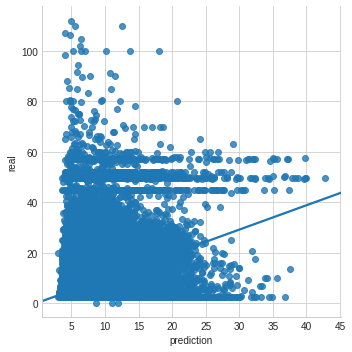

In [27]:
sns.lmplot('prediction','real',data=result, fit_reg=True)

In [32]:
lin_mse = mean_squared_error(y_test, final_prediction)
lin_mse

6.619629395632918

To try improve the performance of these model maybe would be interesting test a boosting method (adaboost or gradient boosting).

Also we could create new variables according with the places of city, to try improve the mistakes of the real fare amount around 40-50. 




#Test

##preparing test set

In [0]:
test_df =  pd.read_csv('test.csv')

In [92]:
test_df.columns

Index(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [0]:
distance_manhattan(test_df)

date_transform(test_df)

In [94]:
print(test_df.isnull().sum())

key                   0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count       0
manh_length          85
hour                  0
year                  0
weekday               0
month                 0
dtype: int64


In [95]:
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,manh_length,hour,year,weekday,month
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9829.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273,4.269319,13.467420,2011.815816,2.852834,6.857979
std,0.042774,0.033541,0.039072,0.035435,1.278747,5.128323,6.868584,1.803347,1.994451,3.353272
min,-74.252193,40.573143,-74.263242,40.568973,1.000000,0.002034,0.000000,2009.000000,0.000000,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000,1.613819,8.000000,2010.000000,1.000000,4.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000,2.728108,15.000000,2012.000000,3.000000,7.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000,4.849854,19.000000,2014.000000,5.000000,10.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000,125.004760,23.000000,2015.000000,6.000000,12.000000


In [0]:
test_df=test_df.dropna()

In [0]:
features=['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'manh_length', 'year', 'hour', 'weekday','month']
X_test_final = test_df[features].values


##testing

In [0]:
prediction_test_df=final_model.predict(X_test_final)

In [0]:
final_result= pd.DataFrame({'key': test_df.key, 'fare_amount': prediction_test_df},columns = ['key', 'fare_amount'])

In [103]:
final_result.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.983333
1,2015-01-27 13:08:24.0000003,9.666667
2,2011-10-08 11:53:44.0000002,3.913333
3,2012-12-01 21:12:12.0000002,10.016667
4,2012-12-01 21:12:12.0000003,15.316667
